Изучить атаку DeepFool, которая предназначена для минимальных изменений в изображениях с целью изменения их классификации.

Загрузим обученную модель и данные MNIST

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('/content/mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9717 - loss: 0.1022
Test accuracy on clean images: 0.9750999808311462


In [ ]:
!pip install foolbox

Реализация атаки DeepFool с использованием Foolbox

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


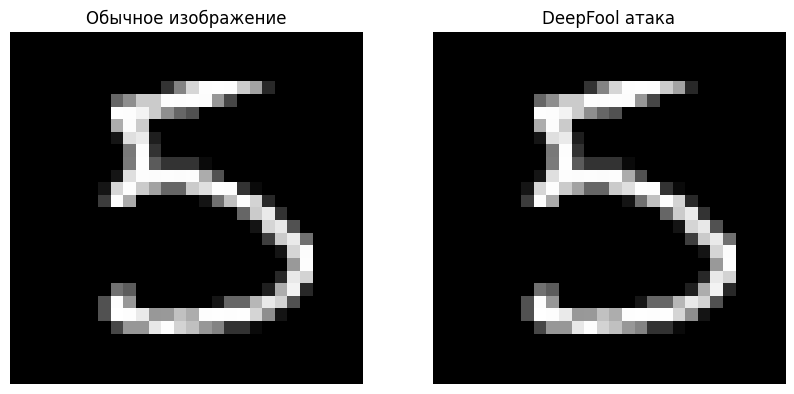

In [ ]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Создание атаки DeepFool
attack = fb.attacks.L2DeepFoolAttack(steps=10)

# Выбор изображения для атаки
image = tf.convert_to_tensor(test_images[15], dtype=tf.float32)[None, ...]
label = tf.convert_to_tensor(np.argmax(test_labels[0]), dtype=tf.int64)

# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Обычное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("DeepFool атака")
plt.imshow(adversarial_image[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

Оценка модели на противоречивых примерах.

In [ ]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []

# Обработка изображений
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0049 - loss: 64.3354
Accuracy on adversarial examples (DeepFool): 0.004900000058114529


In [ ]:
print(f'Test accuracy on clean images: {test_acc}')
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

Test accuracy on clean images: 0.9750999808311462
Accuracy on adversarial examples (DeepFool): 0.004900000058114529
